# Welcome to TXPipe

Kernel: desc-python <br>
Owner: E Phillips Longley, Slack: Emily Phillips Longley, github: ellongley <br> 
Last Verified: 02/22/2019 <br>


TXPipe is a pipeline to perform 3x2 pt analysis on DC2 products.   3x2 pt. refers to the combined analysis of galaxy clustering and weak lensing, and involves the computation of three 2pt. functions, the autocorrelation of galaxy shapes (Shear-Shear) the autocorrelation of galaxy positions (Position-Position) and the cross-correlation of lens galaxy positions and source galaxy shapes (Shear-Position).

This notebook serves to walk through the stages of the pipeline.  The pipeline lives in the TXPipe repo: https://github.com/LSSTDESC/TXPipe.  Each stage of calculation is a python module in this repo.  The pipeline is run as a series of these stages where the outputs of the previous stage are the inputs to the next stage.  This is run through the Parsl workflow system which is described here: https://ceci.readthedocs.io/en/latest/.

In [3]:
import matplotlib
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import treecorr
import h5py   
from math import *
%matplotlib inline
from scipy import stats

# Input Catalog 

The first stage of the pipeline creates mock photometry and shear catalogs.  Later this will be replaced with output catalogs that come from DM run on DC2 images! 

### Details about the Model in the Input Catalogs

The input for this run was proto-dc2-v3.0 and noise was simulated on this extragalactic catalog.


The catalog is simualted in the metacal format, to learn more about metacalibration see this paper: 

https://arxiv.org/pdf/1702.02600.pdf

Metacalibration calibrates shear biases by measuring the response of an object to a shear.  In this catalog these shear responses are simulated based on the DES Year One Model.

R(log10(snr), size) <br>
R_std(log10(snr), size) <br>
where R is the mean metacal response in a bin and <br>
R_std is its standard deviation. 

To see more about this implementation see https://arxiv.org/pdf/1708.01533.pdf. 

In [4]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs
from GCR import GCRQuery

### Load the Catalogs

In [5]:
path = 'TXPipe/outputs/'

In [6]:
shear_catalog_file = path + 'shear_catalog.fits'

In [7]:
photometry_catalog_file = path + 'photometry_catalog.hdf5'

In [8]:
shear_catalog_file = path + 'shear_catalog.fits'

In [9]:
photo_file =  h5py.File(photometry_catalog_file, 'r')
photo_data = photo_file['photometry']

In [10]:
shear_data = Table.read(shear_catalog_file)

In [11]:
#Note the catalogs are in the metacal format "mcal_T_1m" for example refers to the value of T remeasured on an object 
# that has had a negaive applied shear

shear_data

R,dec,id,mcal_T,mcal_T_1m,mcal_T_1p,mcal_T_2m,mcal_T_2p,mcal_T_err,mcal_T_err_1m,mcal_T_err_1p,mcal_T_err_2m,mcal_T_err_2p,mcal_T_r,mcal_T_r_1m,mcal_T_r_1p,mcal_T_r_2m,mcal_T_r_2p,mcal_Tpsf,mcal_flags,mcal_flux [3],"mcal_flux_cov [2,2]",mcal_flux_s2n [3],mcal_g [2],mcal_g_1m [2],mcal_g_1p [2],mcal_g_2m [2],mcal_g_2p [2],"mcal_g_cov [2,2]","mcal_g_cov_1m [2,2]","mcal_g_cov_1p [2,2]","mcal_g_cov_2m [2,2]","mcal_g_cov_2p [2,2]",mcal_gpsf [2],mcal_logsb,mcal_mag [3],mcal_pars [6],mcal_pars_1m [6],mcal_pars_1p [6],mcal_pars_2m [6],mcal_pars_2p [6],"mcal_pars_cov [6,6]","mcal_pars_cov_1m [6,6]","mcal_pars_cov_1p [6,6]","mcal_pars_cov_2m [6,6]","mcal_pars_cov_2p [6,6]",mcal_s2n_r,mcal_s2n_r_1m,mcal_s2n_r_1p,mcal_s2n_r_2m,mcal_s2n_r_2p,mcal_weight,ra,true_g [2]
float64,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
0.7187657510608005,-1.7822555,167,15.71468735288901,15.706054469227709,15.723320236550311,15.706054469227709,15.723320236550311,0.0,0.0,0.0,0.0,0.0,15.71468735288901,15.706054469227709,15.723320236550311,15.706054469227709,15.723320236550311,0.20287899012501048,0,15.501571810910248 .. 16.16279942485643,0.0 .. 0.0,2407.2001770903066 .. 1282.3231800062492,-0.09645707503627221 .. 0.0657335409046564,-0.10364473254688022 .. 0.0657335409046564,-0.08926941752566421 .. 0.0657335409046564,-0.09645707503627221 .. 0.0585458833940484,-0.09645707503627221 .. 0.0729211984152644,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,20.82871310722667 .. 20.565473652746714,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,3422.674145155285,2414.8473729620014,2400.9645963144358,2414.8473729620014,2400.9645963144358,0.0,-0.21368141,2.7837075e-05 .. -6.7863216e-06
0.6099099969465702,-2.0631046,168,1.4619724015448736,1.4553613138523622,1.468583489237385,1.4553613138523622,1.468583489237385,0.0,0.0,0.0,0.0,0.0,1.4619724015448736,1.4553613138523622,1.468583489237385,1.4553613138523622,1.468583489237385,0.20287899012501048,0,12.26245199506279 .. 12.797019546928874,0.0 .. 0.0,734.0159154440009 .. 373.2682505949808,0.10881809945992393 .. -0.43914778028182827,0.10271899949045822 .. -0.43914778028182827,0.11491719942938963 .. -0.43914778028182827,0.10881809945992393 .. -0.445246880251294,0.10881809945992393 .. -0.43304868031236254,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,22.118229932197465 .. 21.90541475665435,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1025.3357349896578,730.1609828692675,739.2393616698646,730.1609828692675,739.2393616698646,0.0,-1.2949525,2.0935136e-05 .. 1.0377686e-06
0.7365752622545041,-1.1909865,169,1.0180114920880723,1.011209878721735,1.0248131054544096,1.011209878721735,1.0248131054544096,0.0,0.0,0.0,0.0,0.0,1.0180114920880723,1.011209878721735,1.0248131054544096,1.011209878721735,1.0248131054544096,0.20287899012501048,0,9.81670388304917 .. 10.098044642648556,0.0 .. 0.0,299.39016690931913 .. 138.74857974915867,0.22003888439577032 .. 0.28130549813681127,0.21267313177322528 .. 0.28130549813681127,0.22740463701831537 .. 0.28130549813681127,0.22003888439577032 .. 0.27393974551426625,0.22003888439577032 .. 0.28867125075935635,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,23.091899792957765 .. 22.97989601919228,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,403.1700629643099,300.4998749662226,299.51717248258024,300.4998749662226,299.51717248258024,0.0,2.4377882,-2.0940024e-05 .. 1.5220379e-05
0.48962883314964034,-0

# TXPhotozPDF

This stage creates photo-z PDF estimates for each object.  The photo-z code that is currently linked to the pipeline is the MLZ code, Machine Learning for photo-Z. https://github.com/mgckind/MLZ This code uses a random forest algorithm to create photo-z estimates.  

In [12]:
path

'TXPipe/outputs/'

In [13]:
!ls TXPipe/outputs/

diagnostic_maps.hdf5	 random_cats.hdf5    tomography_catalog.hdf5
photometry_catalog.hdf5  random_photoz	     twopoint_data.sacc
photoz_pdfs.hdf5	 randoms	     twopoint_output
photoz_stack.hdf5	 shear_catalog.fits


In [14]:
stacked_photozs =  h5py.File(path + 'random_photoz/photoz_stack.hdf5', 'r')

In [15]:
for group in stacked_photozs:
    print(group)

n_of_z


In [16]:
for member in stacked_photozs['n_of_z']:
    print(member)

lens
source


In [17]:
for item in stacked_photozs['n_of_z/lens']:
    print(item)

bin_0
z


We can plot the stacked pdfs to look at the n(z)'s per bin.  Currently these are computed by naively stacking photo-z PDFs in bins however, plans are to change this stage to use CHIPPR which is a method for computing these probabalistically.  https://github.com/aimalz/chippr

### N(z)'s

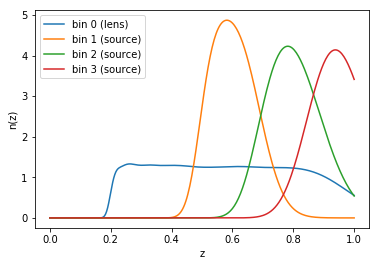

In [21]:
for bin_num in ['0','1','2','3']:
    if bin_num=='0':
        plt.plot(stacked_photozs['n_of_z/lens']['z'],stacked_photozs['n_of_z/lens']['bin_'+bin_num],label='bin '+ bin_num + ' (lens)')
    else:
        plt.plot(stacked_photozs['n_of_z/source']['z'],stacked_photozs['n_of_z/source']['bin_'+bin_num],label='bin '+ bin_num + ' (source)')
plt.legend(loc='best')
plt.ylabel('n(z)')
plt.xlabel('z')
plt.show()

# TXSelector

This pipeline stage selects objects to be used as the source sample for the shear-shear and shear-position calibrations.  It applies some general cuts based on the flags that metacal gives for the objects, and size and S/N cuts
based on the configuration file.  It also splits those objects into tomographic bins according to the choice the user makes in the input file, from the information in the photo-z PDF file.  Once these selections are made it constructs
the quantities needed to calibrate each bin, this consists of two shear response quantities.

Lens selection is done in this stage based on a series of magnitude and color cuts from SDSS: http://www.sdss3.org/dr9/algorithms/boss_galaxy_ts.php

However, this will eventually be linked to RedMagic code.

# TXDiagnosticMaps

This stage computes a depth map using the DR1 method, which takes the mean magnitude of objects close to 5-sigma S/N.  In the future we will add the calculation of other diagnostic maps like airmass for use in systematics tests and covariance mode projection.

In [485]:
import pandas as pd
import numpy as np
import healpy as hp

In [486]:
maps = h5py.File(path + "diagnostic_maps.hdf5",'r')

In [508]:
# The name of the hdf member gives the value that is being mapped, the number at the end of the quantity, example 
# g1_0 refers to the tomographic bin for those values.
for member in maps['maps']:
    print(member)

depth
depth_count
depth_var
g1_0
g1_1
g1_2
g1_3
g2_0
g2_1
g2_2
g2_3
mask
ngal_0
var_g1_0
var_g1_1
var_g1_2
var_g1_3
var_g2_0
var_g2_1
var_g2_2
var_g2_3


### Depth Counts Map

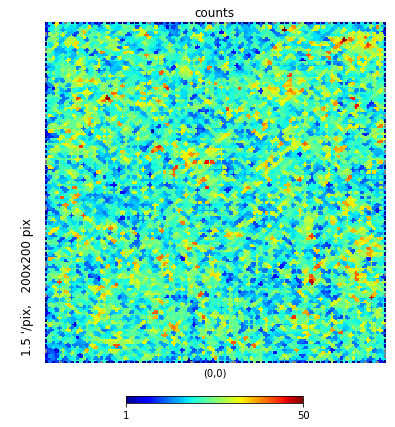

In [488]:
nside = 1024
map_c = np.zeros(hp.nside2npix(nside))
map_c[maps['maps']['depth_count']['pixel'].value]=maps['maps']['depth_count']['value'].value
map_c[map_c==0]=hp.UNSEEN
map_c
hp.gnomview(map_c,title='counts')

### Depth Var Map

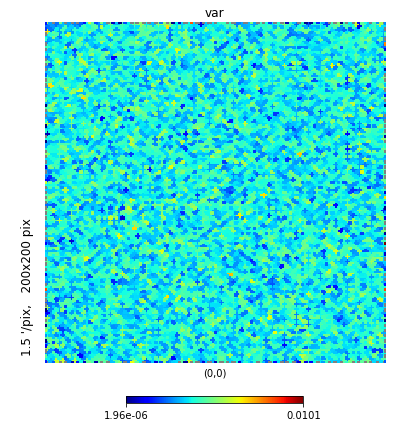

In [490]:
nside = 1024
map_c = np.zeros(hp.nside2npix(nside))
map_c[maps['maps']['depth_var']['pixel'].value]=maps['maps']['depth_var']['value'].value
map_c[map_c==0]=hp.UNSEEN
map_c
hp.gnomview(map_c,title='var')

### Shear Map

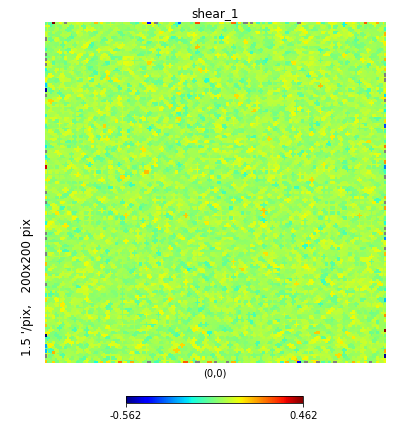

In [491]:
nside = 1024
map_c = np.zeros(hp.nside2npix(nside))
map_c[maps['maps']['g1_0']['pixel'].value]=maps['maps']['g1_0']['value'].value
map_c[map_c==0]=hp.UNSEEN
map_c
hp.gnomview(map_c,title='shear_1')

# TXRandoms

This stage creates a randoms catalog for use in the twopoint calculation.

In [524]:
# Randoms data

randoms = h5py.File(path + "random_cats.hdf5",'r')

ra = randoms['randoms/ra'][:]
dec = randoms['randoms/dec'][:]
ra[ra>180] -= 360

In [528]:
H, xedges, yedges = np.histogram2d(ra, dec,bins=200)

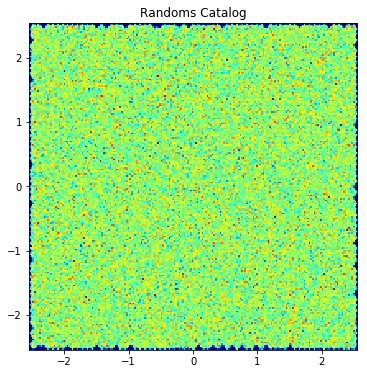

In [531]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(131, title='Randoms Catalog')
plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# TXCov

This stage computes a Gaussian covariance matrix in fourier space.  This is based on the formula in takada and jain 2005: https://arxiv.org/pdf/astro-ph/0310125.pdf (equation 14 is the relevant equation).

In [22]:
# Note one todo for this is to save the covariance output alongside the data vector and n(z) in the SACC output.
cov_path = '/global/homes/e/elp25/TXPipe/'

In [23]:
cov_matrix = np.load(cov_path+'cov_test.npy')

Text(0.5,1,'Gaussian Covariance Matrix Fourier Space')

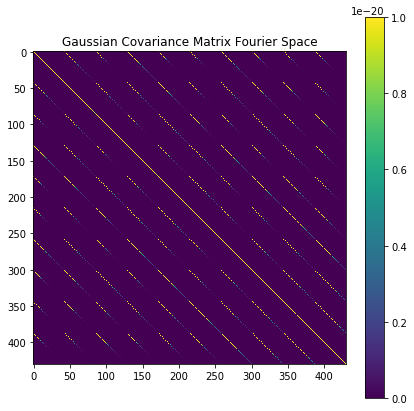

In [25]:
plt.figure(figsize=(7,7))
plt.imshow(cov_matrix,vmin=0.0,vmax=1e-20)
plt.colorbar()
plt.title('Gaussian Covariance Matrix Fourier Space')

# TXTwoPoint

## Output File

Sample output from the pipeline.

In [676]:
path = '/global/cscratch1/sd/elp25/outputs-protoDC2/'

In [680]:
twopoint_data = pd.read_pickle(path + 'twopoint_output')

In [681]:
twopoint_data

,corr_type,error,i,j,npair,theta,value,weight
0,b'xip',1.837807e-08,0,0,2.337232e+06,2.829708,1.824257e-05,2.337232e+06
1,b'xip',1.466154e-08,0,0,3.672338e+06,3.562214,1.490603e-05,3.672338e+06
2,b'xip',1.167647e-08,0,0,5.790001e+06,4.484618,1.242204e-05,5.790001e+06
3,b'xip',9.306546e-09,0,0,9.114326e+06,5.645360,1.053043e-05,9.114326e+06
4,b'xip',7.421348e-09,0,0,1.433296e+07,7.107250,9.054175e-06,1.433296e+07
5,b'xip',5.923591e-09,0,0,2.249736e+07,8.946753,7.875071e-06,2.249736e+07
6,b'xip',4.730155e-09,0,0,3.528182e+07,11.263544,6.844452e-06,3.528182e+07
7,b'xip',3.783454e-09,0,0,5.514736e+07,14.179050,6.137791e-06,5.514736e+07
8,b'xip',3.031052e-09,0,0,8.592409e+07,17.849062,5.533883e-06,8.592409e+07
9,b'xip',2.433607e-09,0,0,1.332910e+08,22.468128,5.209208e-06,1.332910e+08


## Clustering Correlation Function

In [682]:
wtheta = twopoint_data.loc[(twopoint_data["corr_type"]==b'wtheta') & (twopoint_data["i"]==0) & (twopoint_data["j"]==0)]

Text(0.5,1,'Clustering Correlation Function')

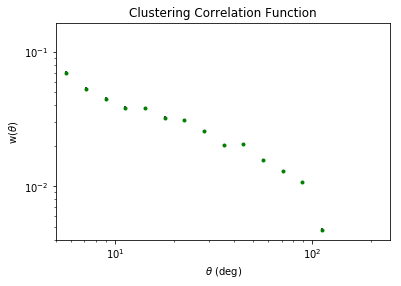

In [695]:
plt.errorbar(wtheta['theta'], wtheta['value'],yerr = wtheta['error'],color='green',fmt='o',ecolor='black',markersize='3')
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlim(5,250)
plt.ylabel(r'w($\theta$)')
plt.xlabel(r'$\theta$ (deg)')
plt.title('Clustering Correlation Function')
#plt.ylim(min(wtheta_lens['value']),max(wtheta_lens['value']))

## Galaxy-Galaxy Lensing Function

In [258]:
gammat = twopoint_data.loc[(twopoint_data["corr_type"]==b'gammat')& (twopoint_data["i"]==3) & (twopoint_data["j"]==0)]

Text(0.5,1,'Galaxy-Galaxy Lensing Correlation Function')

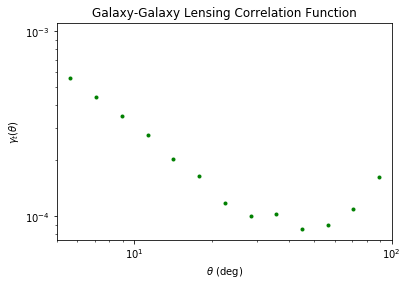

In [708]:
plt.errorbar(gammat['theta'], gammat['value'],yerr = gammat['error'],color='green',fmt='o',markersize=3)
#plt.errorbar(theta_true, gammat_true,label='truth',yerr = gammat['error'],fmt='o')
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlim(5,250)
#plt.ylim(0.000001,0.0003)
plt.ylabel(r'$\gamma_t$($\theta$)')
plt.xlabel(r'$\theta$ (deg)')
#plt.legend(loc='best')
plt.title('Galaxy-Galaxy Lensing Correlation Function')
#plt.ylim(min(wtheta_lens['value']),max(wtheta_lens['value']))

## Cosmic Shear Correlation Function

In [296]:
chi_p = twopoint_data.loc[(twopoint_data["corr_type"]==b'xip')& (twopoint_data["i"]==0) & (twopoint_data["j"]==0)]
#chi_p_sn = twopoint_data_wshapenoise.loc[(twopoint_data["corr_type"]==b'xip')& (twopoint_data["i"]==3) & (twopoint_data["j"]==0)]

In [297]:
chi_m = twopoint_data.loc[(twopoint_data["corr_type"]==b'xim')& (twopoint_data["i"]==0) & (twopoint_data["j"]==0)]

Text(0.5,1,'Cosmic Shear Correlation Function')

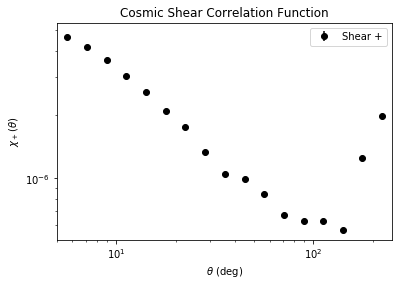

In [699]:
plt.errorbar(chi_p['theta'], chi_p['value'],color='black',yerr=chi_p['error'],label='Shear +',fmt='o')

plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlim(5,250)
#plt.ylim(0.000001,0.00001)
plt.ylabel(r'$\chi_+$($\theta$)')
plt.xlabel(r'$\theta$ (deg)')
plt.legend(loc='best')
plt.title('Cosmic Shear Correlation Function')

Text(0.5,1,'Cosmic Shear Correlation Function')

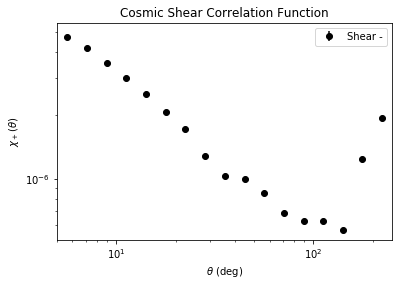

In [701]:
plt.errorbar(chi_m['theta'], chi_m['value'],color='black',yerr=chi_p['error'],label='Shear -',fmt='o')

plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlim(5,250)
#plt.ylim(0.000001,0.00001)
plt.ylabel(r'$\chi_+$($\theta$)')
plt.xlabel(r'$\theta$ (deg)')
plt.legend(loc='best')
plt.title('Cosmic Shear Correlation Function')